# augmentation
* vit model 적용
    - tiny_vit_21m_384.dist_in22k_ft_in1k
    - dropout, normalization 적용
* Augmentation
    - Transpose # 행렬 스왑
    - HorizontalFlip # 좌우 반전
    - VerticalFlip # 상하 반전
    - ShiftScaleRotate # 랜덤하게 옮기고, scale, 회전
* lr scheduler
    - Custom CosineAnnealingWarmUpRestarts
* optimizer
    - AdamW
* sampler 적용
* result
    - train loss : 
    - validation loss : 
    - f1 score : 
    - epoch : 
    - public 점수 : 
    - private 점수 : 

In [1]:
import gc
import os
import random
from datetime import datetime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from tqdm.auto import tqdm

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

import timm

import warnings
warnings.filterwarnings(action='ignore') 

In [2]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [3]:
CFG = {
    'IMG_SIZE': 260,
    'EPOCHS': 1000,
    'LEARNING_RATE': 8e-6,
    'BATCH_SIZE': 16,
    'PATIENCE': 10,
    'WARMUP': 5,
    'FILENAME': 'tiny_vit_sampler',
    'SEED': 6
}

In [4]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

seed_everything(CFG['SEED']) # Seed 고정

In [5]:
running_colab = 'google.colab' in str(get_ipython()) if hasattr(__builtins__,'__IPYTHON__') else False
if running_colab:
    from google.colab import drive
    drive.mount('/content/drive')
if running_colab:
    data_path = '/content/drive/MyDrive/Colab Notebooks/ai6th/data/optiver/'
else:
    data_path = '../../data/'

In [6]:
df = pd.read_csv(os.path.join(data_path, 'train.csv'))
df.loc[3896, 'artist'] = 'Titian'
df.loc[3986, 'artist'] = 'Alfred Sisley'
df.head()

,id,img_path,artist
0,0,./train/0000.jpg,Diego Velazquez
1,1,./train/0001.jpg,Vincent van Gogh
2,2,./train/0002.jpg,Claude Monet
3,3,./train/0003.jpg,Edgar Degas
4,4,./train/0004.jpg,Hieronymus Bosch


In [7]:
artists = df.groupby('artist')[['id']].count().rename(columns={'id':'count'}).reset_index()

In [8]:
# Label Encoding
le = preprocessing.LabelEncoder()
df['artist'] = le.fit_transform(df['artist'].values)

In [9]:
train_df, val_df = train_test_split(df, test_size=0.2, random_state=CFG['SEED'], stratify=df['artist'])

In [10]:
train_df = train_df.sort_values(by=['id'])
train_df.head()

,id,img_path,artist
0,0,./train/0000.jpg,9
1,1,./train/0001.jpg,48
2,2,./train/0002.jpg,7
3,3,./train/0003.jpg,10
4,4,./train/0004.jpg,24


In [11]:
val_df = val_df.sort_values(by=['id'])
val_df.head(20)

,id,img_path,artist
14,14,./train/0014.jpg,15
19,19,./train/0019.jpg,46
20,20,./train/0020.jpg,32
26,26,./train/0026.jpg,37
27,27,./train/0027.jpg,15
28,28,./train/0028.jpg,47
29,29,./train/0029.jpg,28
32,32,./train/0032.jpg,4
33,33,./train/0033.jpg,33
37,37,./train/0037.jpg,33


In [12]:
def get_data(df, infer=False):
    if infer:
        return df['img_path'].apply(lambda p: os.path.join(data_path, p)).values
    return df['img_path'].apply(lambda p: os.path.join(data_path, p)).values, df['artist'].values

In [13]:
train_img_paths, train_labels = get_data(train_df)
val_img_paths, val_labels = get_data(val_df)

In [14]:
from torchvision.transforms import ToTensor


class CustomDataset(Dataset):
    def __init__(self, img_paths, labels, transforms=None):
        self.img_paths = img_paths
        self.labels = labels
        self.transforms = transforms if transforms else ToTensor()

    def __getitem__(self, index):
        img_path = self.img_paths[index]
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = self.transforms(image=image)['image']
        
        if self.labels is not None:
            label = self.labels[index]
            return image, label
        else:
            return image
    
    def __len__(self):
        return len(self.img_paths)

In [15]:
train_transform = A.Compose([
    A.Resize(CFG['IMG_SIZE']*2,CFG['IMG_SIZE']*2),
    A.RandomCrop(CFG['IMG_SIZE'],CFG['IMG_SIZE']),
    A.Transpose(p=0.5), # 행렬 스왑
    A.HorizontalFlip(p=0.5), # 좌우 반전
    A.VerticalFlip(p=0.5), # 상하 반전
    A.ShiftScaleRotate(p=0.5), # 랜덤하게 옮기고, scale, 회전
    # A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=20, val_shift_limit=20, p=0.5), # 빛깔, 색조, 값 변환
    # A.RandomBrightnessContrast(brightness_limit=(-0.1,0.1), contrast_limit=(-0.1, 0.1), p=0.5), # 명도 대비
    # A.ChannelShuffle(), # RGB 채널 간 shuffle
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, always_apply=False, p=1.0),
    # A.CoarseDropout(p=0.5),
    ToTensorV2()
])

validation_transform = A.Compose([
    A.Resize(CFG['IMG_SIZE']*2,CFG['IMG_SIZE']*2),
    A.RandomCrop(CFG['IMG_SIZE'],CFG['IMG_SIZE']),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, always_apply=False, p=1.0),
    ToTensorV2()
])

test_transform = A.Compose([
    A.Resize(CFG['IMG_SIZE'],CFG['IMG_SIZE']),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, always_apply=False, p=1.0),
    ToTensorV2()
])

In [16]:
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2 ** 32
    np.random.seed(worker_seed)
    random.seed(worker_seed)
g = torch.Generator()
g.manual_seed(0)

In [17]:
class_counts = train_df['artist'].value_counts(sort=False).to_dict()
num_samples = sum(class_counts.values())
labels = train_df['artist'].to_list()

class_weights_1 = {l:round(num_samples / class_counts[l], 2) for l in class_counts.keys()}
weights_1 = [class_weights_1[labels[i]] for i in range(int(num_samples))] 
sampler_1 = torch.utils.data.WeightedRandomSampler(torch.DoubleTensor(weights_1), int(num_samples))

class_weights_0_5 = {l:round(num_samples / (class_counts[l] ** 0.5), 2) for l in class_counts.keys()}
weights_0_5 = [class_weights_0_5[labels[i]] for i in range(int(num_samples))] 
sampler_0_5 = torch.utils.data.WeightedRandomSampler(torch.DoubleTensor(weights_0_5), int(num_samples))

class_weights_0_3 = {l:round(num_samples / (class_counts[l] ** 0.3), 2) for l in class_counts.keys()}
weights_0_3 = [class_weights_0_3[labels[i]] for i in range(int(num_samples))] 
sampler_0_3 = torch.utils.data.WeightedRandomSampler(torch.DoubleTensor(weights_0_3), int(num_samples))

In [18]:
train_dataset = CustomDataset(train_img_paths, train_labels, train_transform)


In [19]:
from collections import Counter

In [20]:
plain_loader = DataLoader(
    train_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=True,  
    worker_init_fn=seed_worker, generator=g, num_workers=0
)
plain_counter = Counter()
for _, labels in plain_loader:
    for label in labels:
        plain_counter[label.item()] += 1

In [21]:
loader_1 = DataLoader(
    train_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=False, sampler=sampler_1, 
    worker_init_fn=seed_worker, generator=g, num_workers=0
)
counter_1 = Counter()
for _, labels in loader_1:
    for label in labels:
        counter_1[label.item()] += 1

In [22]:
loader_0_5 = DataLoader(
    train_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=False, sampler=sampler_0_5,
    worker_init_fn=seed_worker, generator=g, num_workers=0
)
counter_0_5 = Counter()
for _, labels in loader_0_5:
    for label in labels:
        counter_0_5[label.item()] += 1

In [23]:
loader_0_3 = DataLoader(
    train_dataset, batch_size = CFG['BATCH_SIZE'], shuffle=False, sampler=sampler_0_3,
    worker_init_fn=seed_worker, generator=g, num_workers=0
)
counter_0_3 = Counter()
for _, labels in loader_0_3:
    for label in labels:
        counter_0_3[label.item()] += 1

<Axes: >

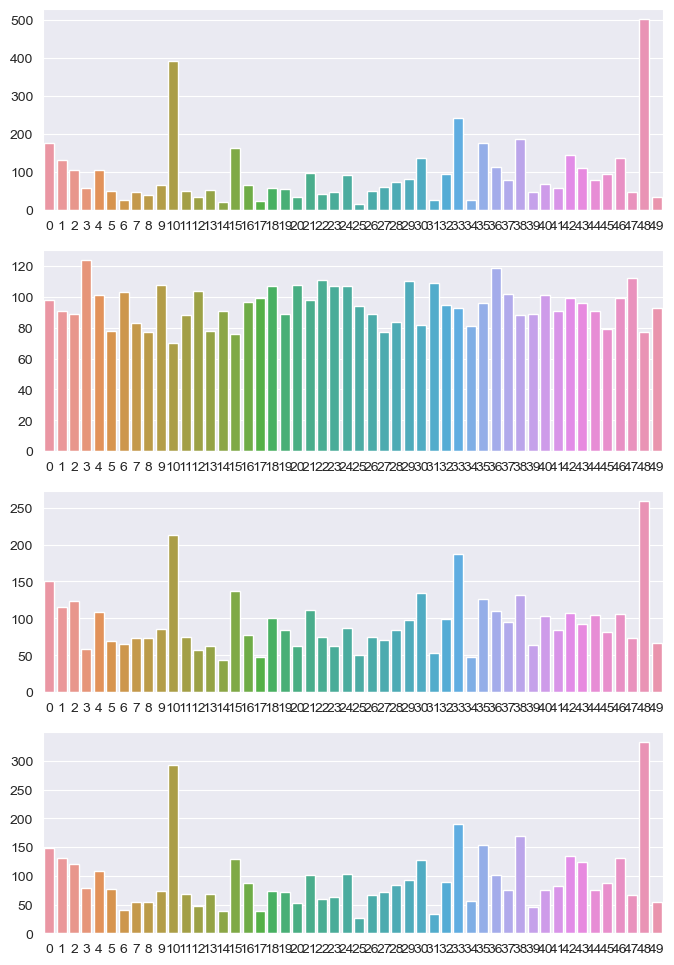

In [24]:
plt.figure(figsize=(8,12))
plt.subplot(4,1,1)
sns.barplot(x=list(plain_counter.keys()), y=list(plain_counter.values()))
plt.subplot(4,1,2)
sns.barplot(x=list(counter_1.keys()), y=list(counter_1.values()))
plt.subplot(4,1,3)
sns.barplot(x=list(counter_0_5.keys()), y=list(counter_0_5.values()))
plt.subplot(4,1,4)
sns.barplot(x=list(counter_0_3.keys()), y=list(counter_0_3.values()))